In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from numpy import poly1d,polyfit  
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import math
import statistics
from scipy.integrate import odeint
from random import randrange # Obtener un numero randomico
import pygame


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#cargamos
data = pd.read_excel('Casos.xlsx')
formatoFecha = '%d/%m/%Y'
#Provincia y fechas
datos = data.iloc[7]
casos = []
for i in datos:
    casos.append(i)
casos.pop(0)

dias = []
for i in range(1, 39):
    dias.append(i)
x = dias
y = casos

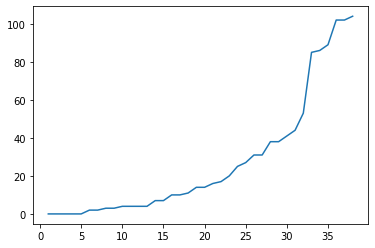

In [3]:
plt.plot(x, y)

[78.31009957] Dia:  1
[80.91169712] Dia:  2
[83.51329467] Dia:  3
[86.11489222] Dia:  4
[88.71648977] Dia:  5
[91.31808732] Dia:  6
[93.91968487] Dia:  7


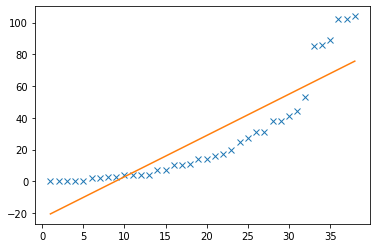

In [4]:
#regresion lineal
lineal = linear_model.LinearRegression()
lineal.fit(np.array(x).reshape(-1,1), y)
plt.plot(x, y, 'x')
plt.plot(x, lineal.predict(np.array(x).reshape(-1, 1)))

j = 1
for i in range(39, 46):
    ##PREDICCION PARA 7 DIAS SIGUIENTES
    prediccion = lineal.predict([[i]])
    print(prediccion, 'Dia: ',j)
    j += 1

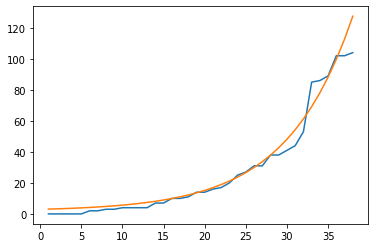

In [5]:
#regresion exponencial
def reg_exponencial(x, c0, c1, c2, c3):
    return c0 * np.exp(-c1 * x) + c2 + c3
g = [100, 0.3, 7, 0.3]
m = []
for i in range(len(x)):
    m.append(reg_exponencial(y[i], g[0], g[1], g[2], g[3]))
    
popt, pcov = curve_fit(reg_exponencial, x, m, g, maxfev=10000)
for i in range(len(x)):
    m[i] = reg_exponencial(x[i], popt[0], popt[1], popt[2], popt[3])
plt.plot(x, y)
plt.plot(x, list(reversed(m)))

[35, 1, 2, 22, 6, 13, 14, 28, 7, 12, 15, 30, 29, 34, 20, 5, 3, 33, 11, 37, 24, 27, 4, 21, 32, 23, 36, 10, 8, 18] [25, 17, 38, 16, 31, 19, 9, 26] [89, 0, 0, 17, 2, 4, 7, 38, 2, 4, 7, 41, 38, 86, 14, 0, 0, 85, 4, 102, 25, 31, 0, 16, 53, 20, 102, 4, 3, 11] [27, 10, 104, 10, 44, 14, 3, 31]


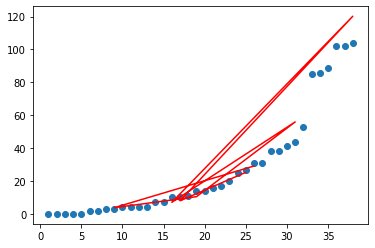

In [11]:
#regresion polinomial
plt.plot(x, y, 'o')
p = poly1d(polyfit(x, y, deg=4))
Xtrain, Xtest, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(Xtrain, Xtest, y_train, y_test)
poli_reg = PolynomialFeatures(degree = 3)
X_train = poli_reg.fit_transform(np.array(Xtrain).reshape(-1,1))
X_test = poli_reg.fit_transform(np.array(Xtest).reshape(-1,1))
pr = linear_model.LinearRegression()
pr.fit(X_train, y_train)
Y_pred_pr = pr.predict(X_test)
#plt.plot(Xtest, y_test)
plt.plot(Xtest, Y_pred_pr, color='red')

antes


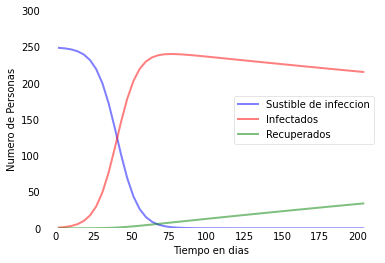

RE: 39759.18143383422


In [12]:
#SIR
N = 250
#Cantidad de infectados iniciales
I0 = 1
#Cantidad de recuperados
R0 = 0
#Poblacion restante suceptibles
S0 = N -I0 - R0
print('antes')
def loss(point, data, S0, I0, R0):
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/N, beta*S*I/N-gamma*I, gamma*I]
        
    solve = solve_ivp(SIR, [0, len(data)], [S0,I0,R0], t_eval = np.arange(0, len(data), 1))
    r = math.sqrt(statistics.mean((solve.y[1] - data)**2))
    return r

opt = minimize(loss, [0.001, 0.001], args=(y, S0, I0, R0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
beta, gamma = opt.x

t = np.linspace(2, 204)


def derivada(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(derivada, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados

#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
ax.set_ylim(0,N*1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()
RE = ((beta/gamma)*N)
print('RE:', RE)

In [ ]:
#Parametros de inicio
PROBA_MUERTE = 8.4  # Probabilidad de que la gente muera COVID
CONTAGION_RATE = beta/gamma  # Factor R0 para la simulacion COVID probabilidad
PROBA_INFECT = CONTAGION_RATE * 10
PROBA_VACU = 0 # Probabilidad de que exista una vacuna, COVID = 0
SIMULACION_SPEED = 50 # Tiempo de un dia en milisegundos (Cada 25 es un dia)
nb_rows = 50 #Numero de filas
nb_cols = 50 #Numero de columnas

global display, myfont, states, states_temp #Declaracion de variables globales

#Declaro colores en formato RGB
WHITE = (255, 255, 255) 
BLUE = (0, 0, 255)
GREEN = (0, 247, 0)
BLACK = (0, 0, 0)

def get_vecinos(x, y):
    incx = randrange(3)
    incy = randrange(3)
    incx = (incx * 1) - 1
    incy = (incy * 1) - 1
    x2 = x + incx
    y2 = y + incy
    #Validar limites
    if x2 < 0:
        x2 = 0
    if x2 >= nb_cols:
        x2 = nb_cols - 1
    if y2 < 0:
        y2 = 0
    if y2 >= nb_rows:
        y2 = nb_rows - 1
    return [x2, y2] # Nuevos contagiados

#Genero las personas que cuentan con inmunidad o vacuna 
def vacunar():
    for x in range(nb_cols):
        for y in range(nb_rows):
            if randrange(99) < PROBA_VACU:
                states[x][y] = 1

#Funcion que permite contar el numero de muertosde la matriz states == -1
def contar_muertes():
    contador = 0
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == -1:
                contador +=  1
    return contador

def contar_recuperados():
    contador = 0
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == 1:
                contador +=  1
    return contador

#Definimos datos de inicio
states = [[0] * nb_cols for i1 in range(nb_rows)]
states_temp = states.copy()
states[randrange(50)][randrange(50)] = 10 # Estado inicial de la simulacion Posicion del Infectado
it = 0 # Variable para contar las Iteraciones
total_muertes = 0 # Contabiliza el numero de muertos
total_recuperados = 0
vacunar() #Llamar a la funcion vacunar

pygame.init() #Incializo el motor de juegos pygame
pygame.font.init() #Inicializo el tipo de letra
display=pygame.display.set_mode((800,750),0,32) #Tamanio de la ventana
pygame.display.set_caption("Simulacion de Epidemia Covid-19 Ecuador")# Titulo
font=pygame.font.SysFont('Calibri', 40) # Tipo de letra
display.fill(WHITE) # Color de fondo
while True:
    pygame.time.delay(SIMULACION_SPEED) # Sleep o pausa
    it = it + 1
    if it <= 10000 and it >= 2:
        states_temp = states.copy() #Copia de la matriz
        #Recorrera la matriz
        for x in range(nb_cols):
            for y in range(nb_rows):
                state = states[x][y]
                if state == -1:
                    pass
                if state >= 10: # Numero de dias de contagio
                    states_temp[x][y] = state + 1
                if state >= 20:
                    if randrange(99) < PROBA_MUERTE: # Genero un randomico para verificar si fallece o se recupera
                        states_temp[x][y] = -1 # Muere
                    else:
                        states_temp[x][y] = 1 # Cura o recupera
                if state >= 10 and state <= 20: # Rango de infectado
                    if randrange(99) < PROBA_INFECT: # Infecto a las personas cercanas entre  10 y 20 
                        neighbour = get_vecinos(x, y) #Obtenemos los vecinos a contagiar
                        x2 = neighbour[0]
                        y2 = neighbour[1]
                        neigh_state = states[x2][y2]
                        if neigh_state == 0: #Verifico que este sano
                            states_temp[x2][y2] = 10 # Contagia
        states = states_temp.copy()
        total_muerte = contar_muertes() # contar el numero de muertos
        total_recuperados = contar_recuperados()
        
    pygame.draw.rect(display, WHITE, (250, 30, 260, 50)) # Grafico el fondo
    textsurface = font.render("Total muertes: "+ str(total_muertes), False, (255,160,122)) #El numero de muertos
    display.blit(textsurface, (250, 30)) # Graficar el texto de muertes
    #Graficar el estado del paciente matriz
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == 0:
                color = BLUE # No infectado
            if states[x][y] == 1:
                color = GREEN # Recupero
            if states[x][y] >= 10:
                color = (states[x][y] * 12, 50, 50) # Injectado - Rojo
            if states[x][y] == -1:
                color = BLACK # Muerto
            pygame.draw.circle(display, color, (100 + x * 12 + 5, 100 + y * 12 + 5), 5)
            pygame.draw.rect(display, WHITE, (100 + x * 12 + 3, 100 + y * 12 + 4, 1, 1))
    #Escuachar los eventos del teclado
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE: #Presiona y Escape
            pygame.quit() #Termino simulacion
        if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE: #Presiona y espacio
            #Reiniciamos valores
            states = [[0] * nb_cols for i1 in range(nb_rows)]
            states_temp = states.copy()
            states[5][5] = 10
            it = 0
            total_muertes = contar_muertes()
            vacunar() #Llamar a la funcion vacunar
           
    pygame.display.update()
    

#### mejor prediccion es la regresion polinomica, la que intenta pasar por su mayoria de puntos
#### Ventaja y desventa, eso siempre dependera del modelo y ademas de tener una buena base de datos en los que las variables tenga algun tipo de relacion, a mi paracer el modelo polinomico saca mucha ventaja con respecto a la lineas, y con respecto al modelo exponencial es algo similar tiene una buena prediccion y de igual manera trata de ajustarse a cada punto.